In [2]:
setwd("~/PavLabEngrams/EngramCellClassifier/RemoteMemory")

# libraries used
library(randomForest)
library(rfUtilities)
library(Seurat)
library(stringr)
library(sampler)
library(caTools)
library(pROC)
library(ggplot2)
library(stats)
library(Dict)
library(pheatmap)
library(caret)
library(data.table)
library(dplyr)
library(aod) #for logistic regression
#library(lme4) apparently lme4 cannot be loaded with seurat

ERROR: Error in library(aod): there is no package called 'aod'


In [ ]:
# sees like this fiel cannot open the connection
# we will have to make plots in a seperate R script
# just add relevant figures here and reference the script

#kwon 
kwon2021_counts <- read.table("~/test_datasets/Kwon2021_GSE145970/kwon2021_mpfc_neurons_counts.csv.gz",
                              header = TRUE, sep =",")
rownames(kwon2021_counts) <- kwon2021_counts$GENE

combined.meta <- read.csv("~/test_datasets/Kwon2021_GSE145970/kwon_mpfc_neurons_meta.csv",
                          header = TRUE)

# there was a discrepancy between the names in kwon meta dat cell id and the counts
# this commented out code is here to fix it
# fun <- function(x){
#    out <- str_c(
#      str_sub(x, start = 1L, end = 12L), 
#      "_", 
#      str_sub(x, start = 13L)
#      )
#    return(out)}
# 
# kwon2021_meta$CellID <- lapply(kwon2021_meta$CellID, FUN = fun)

# filter kwon2021_coutns to match cells in the metadata
kwon2021_counts <- kwon2021_counts[,colnames(kwon2021_counts) %in% kwon2021_meta$CellID ]
kwon2021_meta <- kwon2021_meta[kwon2021_meta$CellID %in% colnames(kwon2021_counts),]

# we're removing chen cells from this step

In [27]:
#Chen
chen2020_counts <- read.csv('~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/GSE152632_GEO_mberkchen_TRAP2_counts.csv.gz', header = TRUE)

rownames(chen2020_counts) <- chen2020_counts$X
chen2020_counts <- chen2020_counts[,2:3531]

# pull the meta data
chen2020_meta <- read.csv( '~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/SraRunTable.txt', header = TRUE)

#add engram label
chen2020_meta$engram_label <-  as.factor(sapply(as.character(colnames(chen2020_counts)), function(y) if (grepl("_pos_", y, fixed=TRUE)) "tdT+" else "tdT-"))

#create the condition label
condition_label <- chen2020_meta$source_name %>%
  sapply( function(y) if (grepl("Homecage", y, fixed=TRUE)) "Homecage")

condition_label <- chen2020_meta$source_name
condition_label[str_detect(condition_label, "Homecage")] = "Homecage"
condition_label[str_detect(condition_label, "Context-Only")] = "Context-Only"
condition_label[str_detect(condition_label, "Fear-Only")] = "Fear-Only"
condition_label[str_detect(condition_label, "Fear-Recall")] = "Fear-Recall"
chen2020_meta$condition_label <- condition_label

#adding cell bacrcodes from coutn data to rows of metadata for seurat
rownames(chen2020_meta) <- colnames(chen2020_counts)

chen2020_meta <- cbind(chen2020_meta, read.csv("~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/Chen2020_ClusterMarkers.csv") )

# add the umi counts to the meta data
chen2020_meta$umi <- as.numeric(colSums(chen2020_counts[,c(1:(dim(chen2020_counts)[2]) )]))

         
#filter counts by genes shared wiht kwon
genes_shared_with_kwon <- read.csv('~/PavLabEngrams/EngramCellClassifier/combinedcountsgenes.csv')
genes_shared_with_kwon <- genes_shared_with_kwon$rownames.combined.counts.
chen2020_counts <- chen2020_counts[rownames(chen2020_counts) %in% genes_shared_with_kwon,]

In [29]:
# FUNCTIONS

# paul prefers a log base that's easy to do headmath with so no eulers numebr
pseudocount_log2p1_transform <- function(x, scale_factor = 10000, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x+1)/counts
  x <- x/scale_factor
  return(log2(x))
}

pavlab.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
#
   df[] <- Map(pseudocount_log2p1_transform, df, UMI.provided = UMI)
  
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}


#normalization functions, log.norm calls logplusone
seurat_log1p_transform <- function(x, scale_factor = 10000, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x+1)/counts
  x <- x/scale_factor
  return(log(x))
}

seurat.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, seurat_log1p_transform))
  }else{
    df[] <- Map(seurat_log1p_transform, df, UMI.provided = UMI)
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}


#normalization functions, log.norm calls logplusone
# mean center scale then log(x+1) for normalizing
logplusone <- function(x){
  return( log(x+1) )
}

log.norm <- function(df.in){
  #performs the lognorm transform and scales the data, removes NA's first
  if( sum(is.na(df.in)) ){
    df.in[is.na(df.in)] <- 0
  }
  df.out <- apply(df.in,
                  MARGIN = 1,
                  FUN = logplusone
  )
  df.out <- scale( t(df.out) ) #we need it transposed so that the scaling is done per gene not cell
  df.out <- data.frame( t(df.out) )
  colnames(df.out) <- rownames(df.in)
  return(df.out)
}

scale.and.rotate<-function(df.in){
  incols <- colnames(df.in)
  inrows <- rownames(df.in)
  df.in <- t(df.in)
  df.in <- scale(df.in)
  df.in <- data.frame(df.in)
  rownames(df.in) <- incols
  colnames(df.in) <- inrows
  return(df.in)
}

celltype.lognorm <-function(countsdata, celltype.labels){
  #log normalizes within cell types in counts data
  #celltype labels and colnames of countsdata must have same order
  
  #retunrs a transposed and normalize dataframe 
  
  print("Normalizing cell type...")
  
  celltypes <- unique(celltype.labels)
  df.out <- data.frame(gene = rownames(countsdata))
  #df.out <- t(df.out)
  #colnames(df.out) <- rownames(countsdata)
  
  cell_names <- colnames(countsdata) # keep this for reorganizing later
  df.out.rownames <- c()
  for(type in celltypes){
    print(type[1])
    normalized.within.type <- log.norm(countsdata[,celltype.labels==type])
    normalized.within.type <- t(normalized.within.type ) # lognomr flips its data
    normalized.within.type <- data.frame(normalized.within.type)
    normalized.within.type <- rownames_to_column(normalized.within.type, var ="gene")
    df.out <- left_join( df.out, normalized.within.type, by = 'gene' )
  }
  
  df.out <- df.out[,2:dim(df.out)[2]] # drops gene column
  df.out <- df.out[cell_names] # to keep original order
  df.out <- t(df.out)
  return( data.frame(df.out) ) 
}



resample.randomForest <-function( df.in,
                                  under_represented_class,
                                  over_represented_class,
                                  proportion,
                                  batches, 
                                  trees){
  #NOTE: df.in should have a column called engram cell with the class labels i.e. postive or negative
  
  #this function resamples from our samples and retrains new models then combines them
  # this is too prevent over fitting on cells
  trees.per.batch <- as.integer(trees/batches)
  n.cells <- trunc( sum(df.in$Engramcell==under_represented_class)*proportion)
  batches <- c(1:batches)
  for( batch in batches){
    resample.set <- rbind(sample(which(df.in$Engramcell==under_represented_class), size = n.cells),
                          sample(which(df.in$Engramcell==over_represented_class), size = n.cells)
    )
    resample.set <- df.in[resample.set,]
    
    # creates rf.model
    if(batch==1){
      rf.model <- randomForest(x = resample.set[,1:(length(resample.set)-1)],
                               y = resample.set$Engramcell,
                               ntree = trees.per.batch)
    }
    #trains new models in rf.fit and combines tham with rf.model
    if(batch>1){
      rf.fit = randomForest(x = resample.set[,1:(length(resample.set)-1)],
                            y = resample.set$Engramcell,
                            ntree = trees.per.batch)
      rf.model <- randomForest::combine(rf.fit, rf.model)
    }
  }#end of for loop over batches
  
  return(rf.model)
}


make.predictions.df <- function(classifier.object, 
                                test_df,
                                meta.data.label.column,
                                label = c("Active","Inactive")
){
  #generate predictions for making classifier summary
  predictions <- as.data.frame(predict(classifier.object, test_df[,1:(length(test_df))], type = "prob"))
  predictions$predict <- names(predictions)[1:2][apply(predictions[,1:2], 1, which.max)] #1:2 for the number of classes
  predictions$observed <- meta.data.label.column #this should be changed if you want to make this functions more modular
  colnames(predictions)[1:2] <- c("label_pos","label_neg")
  predictions$engramobserved <- ifelse(predictions$observed==label[1], 1, 0)
  predictions$inactiveobserved <- ifelse(predictions$observed==label[2], 1, 0)
  return(predictions)
}


# assess a single run of resampled.randomforest
assessment <- function(predictions.df, 
                       label = c("Active","Inactive") 
){
  # returns a vector of assessments to be used to make dataframe summarizing classifiers performance
  # can be used to make df of all calssifiers trained in a single run
  TP <- sum((predictions.df$predict == label[1])&(predictions.df$observed == label[1]))
  TN <- sum((predictions.df$predict == label[2])&(predictions.df$observed == label[2]))
  FN <- sum((predictions.df$predict == label[2])&(predictions.df$observed == label[1]))
  FP <- sum((predictions.df$predict == label[1])&(predictions.df$observed == label[2]))
  
  #precision and recall as well as sumamry stats F1
  precision <- TP/(TP+FP)
  recall <- TP/(TP+FN)
  F1.score = 2 * (precision * recall) / (precision + recall)
  FPR <- FP/(TN+FP)
  FNR <- FN/(TP+FN)
  
  #getting auc
  roc.engramcell <- roc(predictions.df$engramobserved, as.numeric(predictions.df$label_pos) )
  AUC <- auc(roc.engramcell)
  
  return( c(F1.score, AUC, precision, recall, FPR, FNR,
            TP, FN, TN, FP) )
}



resampled.randomForest.crossvalidated <-function(data,
                                                 under.represented.class,
                                                 over.represented.class,
                                                 folds,
                                                 trees.total,
                                                 proportion.each.batch=0.8,
                                                 batches.per.fold=20){
  # takes a data frame with a label column assumed to be named Engramcell, data$Engramcell
  # returns a model that has been k-fold cross validated, with an attribute called Assessment
  # assessment has the performance metrics of all the folds and a column of means and SD's for each
  # metric
  #NOTE: ROC curve needs to be implemented
  
  folds.obj <- createFolds(data$Engramcell, k = folds)
  loops <- c(1:folds)
  for( i in loops ){
    #create indices
    test.idx <- folds.obj[[i]]
    # needs to be a list so it can act as an index
    train.idx <- which(!(rownames(data) %in% test.idx) )
    
    #split data for this fold
    training_set <- data[train.idx,]
    testing_set <- data[test.idx,]
    
    # divvies up number of trees
    trees.in.the.fold = as.integer(trees.total/folds)
    if ( ( trees.total%%(batches.per.fold*folds) )>0  ){ 
      stop("Number of trees does not devide evenly by batches and folds.")
    }
    # we still need to settle on stuff to 
    rf.this_fold <- resample.randomForest(df.in = training_set,
                                          under_represented_class = under.represented.class,
                                          over_represented_class = over.represented.class,
                                          proportion= proportion.each.batch,
                                          batches = batches.per.fold, 
                                          trees = trees.in.the.fold)
    
    if(i == 1){
      rf.out <- rf.this_fold
      pred <- make.predictions.df(rf.this_fold, testing_set[1:(length(testing_set)-1)], testing_set$Engramcell)
      assess <- assessment( pred ) 
      fold.performance <- data.frame(assess )
      rownames(fold.performance) <- c("F1 Score", "AUC", "Precision", "Recall",
                                      "FPR", "FNR", "True Positives", "False Negatives", 
                                      "True Negatives", "False Positives")
    }else{
      rf.out <- randomForest::combine(rf.out, rf.this_fold)
      # we need votes for all cells to calculate
      pred <- make.predictions.df(rf.this_fold, testing_set[1:(length(testing_set)-1)], testing_set$Engramcell)
      assess <- assessment( pred ) 
      fold.performance[,ncol(fold.performance) + 1] <- assess
    }
    
  }# end of for loop
  colnames(fold.performance) <- names(folds.obj)
  fold.performance$Mean <- apply(fold.performance,MARGIN=1,  FUN = mean)
  fold.performance$SigDiff <- apply(fold.performance,MARGIN=1,  FUN = sd)
  rf.out$Assessment <- fold.performance
  
  #votes needs to be updated to make roc curve
  rf.out$votes <- predict(object = rf.out, newdata = data, type = 'vote', norm.votes = FALSE)
  return(rf.out)
}


resample.regularizedRF <- function( df.in,
                                    under_represented_class,
                                    over_represented_class,
                                    proportion,
                                    batches, 
                                    trees){
  #NOTE: df.in should have a column called engram cell with the class labels i.e. postive or negative
  
  #this function resamples from our samples and retrains new models then combines them
  # this is too prevent over fitting on cells
  trees.per.batch <- as.integer(trees/batches)
  n.cells <- trunc( sum(df.in$Engramcell==under_represented_class)*proportion)
  batches <- c(1:batches)
  for( batch in batches){
    resample.set <- rbind(sample(which(df.in$Engramcell==under_represented_class), size = n.cells),
                          sample(which(df.in$Engramcell==over_represented_class), size = n.cells)
    )
    resample.set <- df.in[resample.set,]
    
    # creates rf.model
    if(batch==1){
      rf.model <- RRF(x = resample.set[,1:(length(resample.set)-1)],
                      y = resample.set$Engramcell,
                      ntree = trees.per.batch)
    }
    #trains new models in rf.fit and combines tham with rf.model
    if(batch>1){
      rf.fit = RRF(x = resample.set[,1:(length(resample.set)-1)],
                   y = resample.set$Engramcell,
                   ntree = trees.per.batch)
      rf.model <- RRF::combine(rf.fit, rf.model)
    }
  }#end of for loop over batches
  
  return(rf.model)
}

#
resampled.regularizedRF.crossvalidated <-function(data,
                                                  under.represented.class,
                                                  over.represented.class,
                                                  folds,
                                                  trees.total,
                                                  proportion.each.batch=0.8,
                                                  batches.per.fold=20){
  # takes a data frame with a label column assumed to be named Engramcell, data$Engramcell
  # returns a model that has been k-fold cross validated, with an attribute called Assessment
  # assessment has the performance metrics of all the folds and a column of means and SD's for each
  # metric
  #NOTE: ROC curve needs to be implemented
  
  folds.obj <- createFolds(data$Engramcell, k = folds)
  loops <- c(1:folds)
  for( i in loops ){
    #create indices
    test.idx <- folds.obj[[i]]
    # needs to be a list so it can act as an index
    train.idx <- which(!(rownames(data) %in% test.idx) )
    
    #split data for this fold
    training_set <- data[train.idx,]
    testing_set <- data[test.idx,]
    
    # divvies up number of trees
    trees.in.the.fold = as.integer(trees.total/folds)
    if ( ( trees.total%%(batches.per.fold*folds) )>0  ){ 
      stop("Number of trees does not devide evenly by batches and folds.")
    }
    # we still need to settle on stuff to 
    rf.this_fold <- resample.regularizedRF(df.in = training_set,
                                           under_represented_class = under.represented.class,
                                           over_represented_class = over.represented.class,
                                           proportion= proportion.each.batch,
                                           batches = batches.per.fold, 
                                           trees = trees.in.the.fold)
    
    if(i == 1){
      rf.out <- rf.this_fold
      pred <- make.predictions.df(rf.this_fold, testing_set[1:(length(testing_set)-1)], testing_set$Engramcell)
      assess <- assessment( pred ) 
      fold.performance <- data.frame(assess )
      rownames(fold.performance) <- c("F1 Score", "AUC", "Precision", "Recall",
                                      "FPR", "FNR", "True Positives", "False Negatives", 
                                      "True Negatives", "False Positives")
    }else{
      rf.out <- RRF::combine(rf.out, rf.this_fold)
      # we need votes for all cells to calculate
      pred <- make.predictions.df(rf.this_fold, testing_set[1:(length(testing_set)-1)], testing_set$Engramcell)
      assess <- assessment( pred ) 
      fold.performance[,ncol(fold.performance) + 1] <- assess
    }
    
  }# end of for loop
  colnames(fold.performance) <- names(folds.obj)
  fold.performance$Mean <- apply(fold.performance,MARGIN=1,  FUN = mean)
  fold.performance$SigDiff <- apply(fold.performance,MARGIN=1,  FUN = sd)
  rf.out$Assessment <- fold.performance
  
  #votes needs to be updated to make roc curve
  rf.out$votes <- predict(object = rf.out, newdata = data, type = 'vote', norm.votes = FALSE)
  return(rf.out)
}



gene.shuffle <-function(dat){
  #shuffles the genes valus within cells,
  #intended to be applied before normalization
  for ( cell in c(1:ncol(dat)) ){
    rand <- sample(nrow(dat)) # generates random vector of numbers from colls
    dat[,cell] <- dat[rand,cell] # shuffles the genes within cells
    
  }# end of loop over cells
  return(dat)
}

In [31]:
# doing it with the pavlab log2p1
chen_normed <- pavlab.normalize(chen2020_counts, UMI = chen2020_meta$umi)

chen_normed <- scale.and.rotate(chen_normed)
chen_normed <- chen_normed[,!(names(chen_normed) %in% "TdTom-transgene")]
chen_normed$Engramcell <- chen2020_meta$condition_label == "Fear-Recall" & chen2020_meta$engram_label == "tdT+"

glut_chen_normed <- chen_normed[chen2020_meta$BroadCellTypes =='Excitatory',]
glut_chen_normed$Engramcell <- as.factor(glut_chen_normed$Engramcell)
levels(glut_chen_normed$Engramcell) <- c("Inactive", "Active")


In [33]:
# split the data into training and test
split <- sample.split(glut_chen_normed$Engramcell, SplitRatio = 0.7)

training_set = subset(glut_chen_normed, split == TRUE)
validation_set = subset(glut_chen_normed, split == FALSE)


In [35]:
split.classifier.Excitatory_mpfc <-  resampled.randomForest.crossvalidated( data = training_set,
                                                     under.represented.class = "Active",
                                                     over.represented.class = "Inactive",
                                                     trees.total = 800,
                                                     folds = 10,
                                                     proportion.each.batch=0.8,
                                                     batches.per.fold=20)

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases



In [36]:
# how we saved the resulting classifier
# save the model object...
saveRDS(split.classifier.Excitatory_mpfc, "~/EngramCellModels/withheld_data_Excitatory_mpfc_remotememory_rf.RDS")
# save the cells it was traininged on as a dataframe
write.csv(data.frame(rownames(training_set)),'training_cells_chen2020_witheld_classifier')

In [47]:
# getting roc curve on witheld data
predictions_withheld <- as.numeric(predict(split.classifier.Excitatory_mpfc, 
                                  validation_set,
                                  type="response"))

names(predictions_witheld) <- names(validation_set$Engramcell)

In [51]:
predictions_withheld <- data.frame(y = predictions_withheld)

In [56]:
table(predictions_withheld$y)


  1   2 
373 377 

In [52]:
# Calculate AUC
auc <- predictions_withheld %>%
  group_by(y) %>%
  summarise(n = n()) %>%
  mutate(prop = n/sum(n)) %>%
  summarise(auc = sum(prop[y == 1]))

In [53]:
auc

auc
<dbl>
0.4973333


In [58]:
# Plot AUC
ggplot(roc.engramcell, aes(x = true, y = pred)) +
  geom_point(aes(colour = factor(true))) +
  geom_abline(intercept = 0, slope = 1, colour = "red") +
  geom_area(aes(fill = factor(true)), alpha = 0.2) +
  geom_text(aes(label = round(auc, 3)), x = 0.5, y = 0.5, size = 5) +
  labs(title = "AUC Curve", x = "True", y = "Predicted") +
  scale_fill_discrete(name = "True") +
  scale_colour_discrete(name = "True") +
  theme_bw()

ERROR: [1m[33mError[39m in `fortify()`:[22m
[1m[22m[33m![39m `data` must be a [34m<data.frame>[39m, or an object coercible by `fortify()`,
  not an S3 object with class [34m<roc>[39m.


Setting levels: control = Inactive, case = Active

Setting direction: controls < cases



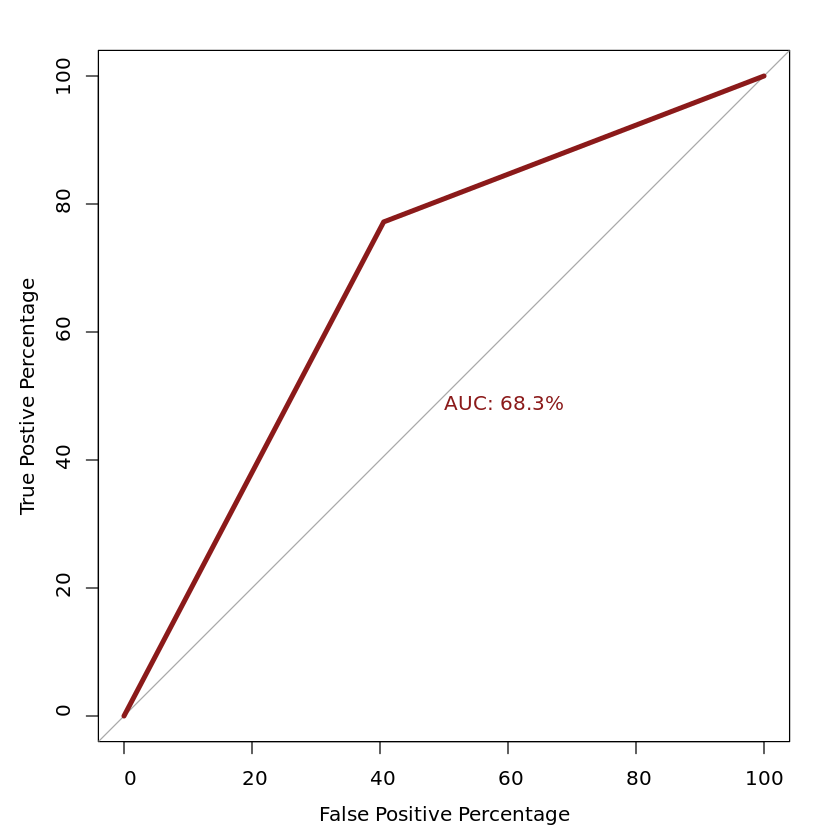

In [37]:
# the roc is quite good again, 
roc.engramcell = roc(validation_set$Engramcell,
                     predictions_witheld, 
                     plot=TRUE, legacy.axes=TRUE, percent=TRUE,
                     xlab="False Positive Percentage", ylab="True Postive Percentage", 
                     col="firebrick4", lwd=4, print.auc=TRUE)

In [45]:
str(roc.engramcell)

List of 15
 $ percent           : logi TRUE
 $ sensitivities     : num [1:3] 100 77.2 0
 $ specificities     : num [1:3] 0 59.4 100
 $ thresholds        : num [1:3] -Inf 1.5 Inf
 $ direction         : chr "<"
 $ cases             : num [1:193] 1 2 1 2 2 2 2 2 1 1 ...
 $ controls          : num [1:557] 1 1 1 1 1 1 1 1 1 1 ...
 $ fun.sesp          :function (thresholds, controls, cases, direction)  
 $ auc               : 'auc' num 68.3
  ..- attr(*, "partial.auc")= logi FALSE
  ..- attr(*, "percent")= logi TRUE
  ..- attr(*, "roc")=List of 15
  .. ..$ percent           : logi TRUE
  .. ..$ sensitivities     : num [1:3] 100 77.2 0
  .. ..$ specificities     : num [1:3] 0 59.4 100
  .. ..$ thresholds        : num [1:3] -Inf 1.5 Inf
  .. ..$ direction         : chr "<"
  .. ..$ cases             : num [1:193] 1 2 1 2 2 2 2 2 1 1 ...
  .. ..$ controls          : num [1:557] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  .. ..$ auc  

In [39]:
# over all performance on witheld data
assess_on_withheld <- assessment(predict(split.classifier.Excitatory_mpfc, 
                                  validation_set,
                                  type="response")) 
performance_on_witheld_data <- data.frame(assess_on_withheld )
performance_on_witheld_data 

ERROR: Error: $ operator is invalid for atomic vectors
